In [1]:
%matplotlib inline
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np


# Coverage Plot of a Ranking Classifier

## First part: load the data and fit a scoring classifier

- load the breast cancer dataset using the sklearn.datasets module;
- import the learning algorithm of your choice (e.g., `linear_model.LogisticRegression`);
- use the fit method to learn a new classifier specifying that you want the classifier to be setup to output probability estimates (use parameter 'probability=True' when instantiating the class);
- use the learnt classifier to obtain the scores for the objects in the training set (use the `predict_proba` method);

## Second part: ranking and coverage plot

- Use the scores you just obtained to rank the examples (from higher to lower probability of being in class 1);
- consider all possible classifiers you can obtain from such order by splitting the sequence in two and then deciding to label everything on the left as positive and everything on the right as negative);
- evaluate the number of false positive examples (FP) and the number of true positive examples (TP) for each split;
- plot those values on a scatter plot (hint: use the `matplotlib.pyplot.plot` function);

## Third part: ranking error and the area under the coverage plot

- Write a function `coverage_area` that given a set of (FP,TP) points, evaluates the area under the curve specified by those points;
- Write the function `ranking error` that evaluates the ranking error: 
$$
error=\frac{\sum_{{x^+} \in \mathrm{Pos} }\sum_{{x^-} \in \mathrm{Neg} } I\left[\hat{s}(x^+) < \hat{s}(x^-)\right] + \frac{1}{2} I\left[\hat{s}(x^+) = \hat{s}(x^-)\right]}{\mathrm{|Pos|}\times\mathrm{|Neg|}}
$$
- Verify that $1$ minus the coverage area equals the ranking error.

### Hints:
To write the `coverage_area` function you might want to sum all the rectangles having sides $\Delta \mathrm{TP}$ and $\mathrm{Neg} - \mathrm{FP}$ (see also the picture below and notice that you should assume that the sequence of (FP,TP) points is sorted). 

<img src="./cov-area.png">

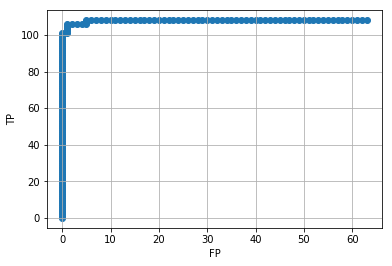

In [2]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

#Split dataset and labels in training set and test set, with respectives labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state = 42)

#positive and negative count
pos = [i for i,t in enumerate(y_test) if t == 1]
neg = [i for i,t in enumerate(y_test) if t == 0]

clf = LogisticRegression()
clf.fit(X_train, y_train)
y_predicted = clf.predict(X_test)
y_predicted_proba = clf.predict_proba(X_test)

#sorting examples 
proba = {i: x for i, x in enumerate(y_predicted_proba, start=0)}
ranking = sorted(proba.keys(), key=lambda x: proba[x][1], reverse=True)

#creation of all the possible classifiers 
x = []
y = []

for i in range (0, len(ranking)+1):
    classifiers = {}
    TP = 0
    FP = 0
    for j in range(0, len(ranking)):
        if(j < i):
            #positive
            classifiers.update({ranking[j]: 1})
        else:
            #negative
            classifiers.update({ranking[j]: 0})
            
    #TP and FP count
    for j in range(0, len(classifiers)):
        if(classifiers[j] == 1):
            if(y_test[j] == 1):
                TP += 1
            else:
                FP += 1
    x.insert(i, FP)
    y.insert(i, TP)
plt.scatter(x, y)
plt.ylabel('TP')
plt.xlabel('FP')
plt.grid(True)
plt.show()


## Interpretazione del grafico
Considero tutti i possibili classificatori che è possibile ottenere dal ranking. In particolare considero un classificatore che classifica *N-i* esempi come positivi e *i* negativi, per *i=1,..,N-1 e N = |y_test|*.
Praticamente all'inizio tutti gli esempi, tranne l'ultimo vengono considerati positivi, poi gli ultimi 2, 3, ecc. Alla fine avremo che solo il primo esempio considerato è positivo e tutti i restanti sono negativi.

Il grafico indica esattamente questo: considerando all'inizio tutti gli esempi come positivi tranne 1, predirrò bene tutti gli esempi positivi, ma commetterò anche molti errori sugli esempi negativi, che considero positivi. Man mano vado avanti continuo a beccare esempi positivi e il tasso di FP diminuisce, perché considero man mano sempre più esempi negativi. La situazione ottimale è rappresentata dal punto in alto a sinistra, che è più vicino al ROC heaven, in quanto becco quasi tutti gli esempi positivi e il numero di falsi positivi è minimo, di conseguenza anche gli esempi negativi sono ben classificati. 

Andando avanti e considerando sempre più esempi come negativi, ovviamente il numero di falsi positivi diminuisce fino a 0 perché prediciamo bene gli esempi negativi, ma il numero di veri positivi si azzera perché non siamo in grado di predirli e di conseguenza, anche se dal grafico non si vede, avremo un alto tasso di falsi negativi, che sono gli esempi positivi considerati erroneamente negativi.

Confusion matrix, without normalization
[[ 59   4]
 [  2 106]]


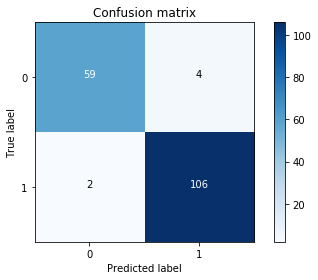

In [3]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_predicted)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0,1], title='Confusion matrix')

In [4]:
def cov_area(x, y):
    area = 0
    for i in range(0, len(x) - 1):
        h = y[i+1] - y[i]
        b = len(neg) - x[i]
        area += (h*b)
    return area

def rank_err():
    denom = len(pos) * len(neg)
    error = 0
    for i in range(0, len(pos)):
        for j in range(0, len(neg)):
            if(proba[pos[i]][1] < proba[neg[j]][1]):
                error += 1
            if(proba[pos[i]][1] == proba[neg[j]][1]):
                error += 0.5
    
    return error/denom

auc = cov_area(x, y)
r_e = rank_err()
print("Normalized coverage area: "+ str(auc/(len(pos)*len(neg))))
print("Ranking error: " + str(r_e))
print("1 - coverage area: " + str((1-auc/(len(pos)*len(neg)))))

Normalized coverage area: 0.9977954144620811
Ranking error: 0.002204585537918871
1 - coverage area: 0.0022045855379189128
